In [1]:
import re
import multiprocessing
from tqdm import tqdm

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import norm
from gensim.models import word2vec
# from kaggle.competitions import twosigmanews

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

%matplotlib inline

In [2]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 55


In [3]:
# env = twosigmanews.make_env()
# print('Done!')

In [4]:
# (market_train_df, news_train_df) = env.get_training_data()
market_train_df = pd.read_csv("market_train_df.csv")
news_train_df = pd.read_csv("news_train_df.csv")

In [5]:
assetName = 'Companhia de Bebidas das Americas Ambev'

In [6]:
df = market_train_df[market_train_df['assetName']==assetName]
df_news = news_train_df[news_train_df['assetName'] == assetName]

In [42]:
df_news.head()

,Unnamed: 0,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,...,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
43155,43155,2007-01-25 12:17:56+00:00,2007-01-25 12:17:56+00:00,2007-01-25 12:17:56+00:00,6b400521352cca5b,AmBev Announces the Commencement of the Volunt...,3,1,PRN,"{'MRG', 'LATAM', 'NEWR', 'BR', 'BACT', 'BEV', ...",...,0,0,0,0,0,0,0,0,0,0
43188,43188,2007-01-25 12:21:57+00:00,2007-01-25 12:21:57+00:00,2007-01-25 12:18:53+00:00,84e2d80db01e7ece,AMBEV SAYS APPROVAL FROM COMMISSION DU SURVEIL...,1,3,RTRS,"{'LATAM', 'BR', 'BEV', 'US', 'RTRS', 'REGS', '...",...,1,1,1,1,1,2,2,2,2,2
43192,43192,2007-01-25 12:22:29+00:00,2007-01-25 12:22:29+00:00,2007-01-25 12:18:53+00:00,21a6c31f991664ea,AMBEV <ABV.N> SAYS PURCHASE PRICE WILL BE U.S....,1,4,RTRS,"{'LATAM', 'BR', 'BEV', 'US', 'RTRS', 'REGS', '...",...,1,1,1,1,1,3,3,3,3,3
43487,43487,2007-01-25 12:38:54+00:00,2007-01-25 12:38:54+00:00,2007-01-25 12:18:53+00:00,001118d2ae80b427,AmBev <AMBV4.SA> to start Quinsa offer,3,1,RTRS,"{'LATAM', 'BR', 'BEV', 'US', 'RTRS', 'REGS', '...",...,0,0,0,0,0,4,4,4,4,4
43510,43510,2007-01-25 12:44:17+00:00,2007-01-25 12:44:17+00:00,2007-01-25 12:44:17+00:00,28145fde39ad98c6,INBEV <INTB.BR> SAYS AMBEV STARTS VOLUNTARY OF...,1,1,RTRS,"{'EUROPE', 'LATAM', 'BR', 'WEU', 'BEV', 'BE', ...",...,0,0,0,0,0,5,5,5,5,5


In [8]:
data_from = '2012-03-10'
data_to = '2014-09-10'

df_small = df[ (df['time']>data_from) & (df['time'] < data_to)]
df_news_small = df_news[(df_news['time'] > data_from) & (df_news['time'] < data_to)]

"\nplt.subplot(2,1,2)\nplt.plot(df_news_small['time'], df_news_small['sentimentNegative'], '--ro', label='Neg')\nplt.plot(df_news_small['time'], df_news_small['sentimentNeutral'], '--bo', label='Neu')\nplt.plot(df_news_small['time'], df_news_small['sentimentPositive'], '--go', label='Pos')\nplt.legend()\n"

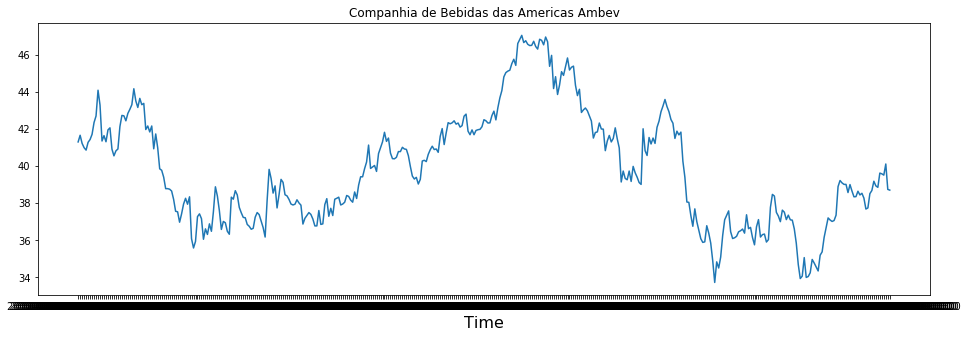

In [9]:
plt.figure(figsize=(16,5))

#plt.subplot(2,1,1)
plt.plot(df_small['time'], df_small['close'])
plt.title(assetName)
plt.xlabel('Time', fontsize=16)
'''
plt.subplot(2,1,2)
plt.plot(df_news_small['time'], df_news_small['sentimentNegative'], '--ro', label='Neg')
plt.plot(df_news_small['time'], df_news_small['sentimentNeutral'], '--bo', label='Neu')
plt.plot(df_news_small['time'], df_news_small['sentimentPositive'], '--go', label='Pos')
plt.legend()
'''

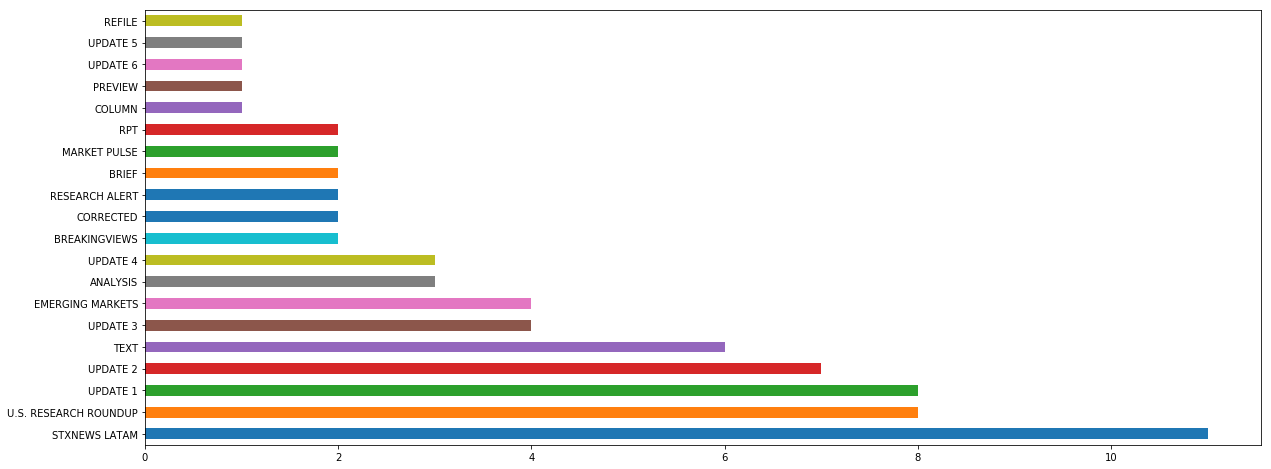

In [10]:
plt.figure(figsize=(20,8))
pd.value_counts(df_news_small['headlineTag']).plot(kind="barh")

In [11]:
df_news_small['headline'].head()

4521683    JP MORGAN RAISES GRUPO MODELO <GMODELOC.MX> PR...
4521684    JP MORGAN RAISES CCU <CCU.N> PRICE TARGET TO $...
4521687    BRIEF-RESEARCH ALERT-JP Morgan raises Ambev, o...
4529005    STXNEWS LATAM-Buy Vale, Itaú; sell Usiminas, H...
4539144      MOODY'S COMMENTS ON ABI ACQUISITION SPECULATION
Name: headline, dtype: object

In [12]:
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str(corpus))
    return wordCloud

In [13]:
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

In [14]:
corpus = get_corpus(df_news_small['headline'].values)
procWordCloud = get_wordCloud(corpus)

In [15]:
df_news_small['headline'].head()

4521683    JP MORGAN RAISES GRUPO MODELO <GMODELOC.MX> PR...
4521684    JP MORGAN RAISES CCU <CCU.N> PRICE TARGET TO $...
4521687    BRIEF-RESEARCH ALERT-JP Morgan raises Ambev, o...
4529005    STXNEWS LATAM-Buy Vale, Itaú; sell Usiminas, H...
4539144      MOODY'S COMMENTS ON ABI ACQUISITION SPECULATION
Name: headline, dtype: object

Text(0.5, 0, 'Number of words in headline news')

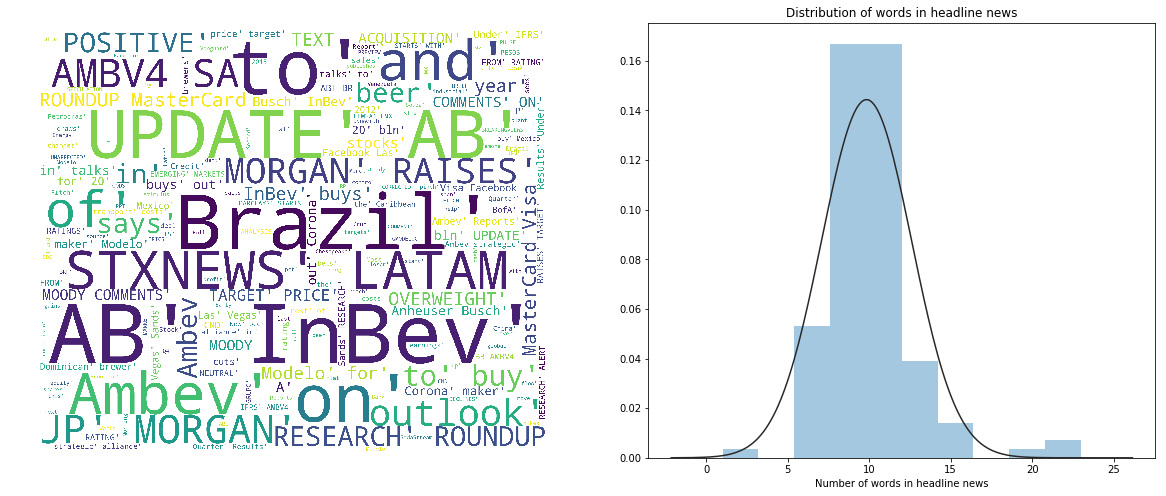

In [16]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1,2,2)

words_count = [len(x.split(' ')) for x in df_news_small['headline'].values]
sns.distplot(words_count,hist=True, kde=False, bins=10, fit=norm)
plt.title("Distribution of words in headline news")
plt.xlabel('Number of words in headline news')

**Text Features Extraction**

In [19]:
#from:https://github.com/RenatoBMLR/nlpPy/tree/master/src

class TextDataset():

    def __init__(self, df, lang = 'english'):

        self.data = df

        self.tokenizer = TweetTokenizer()
        self.stop_words = set(stopwords.words(lang))
        self.lemmatizer = WordNetLemmatizer()
        self.ps = PorterStemmer()
        
    def _get_tokens(self, words):    
        return [word.lower() for word in words.split()]
    
    def _removeStopwords(self, words):
        # Removing all the stopwords
        return [word for word in words if word not in self.stop_words]

    def _removePonctuation(self, words):
        return re.sub(r'[^\w\s]', '', words)

    def _lemmatizing(self, words):
        #Lemmatizing
        return [self.lemmatizer.lemmatize(word) for word in words]

    def _stemming(self, words):
        #Stemming
        return [self.ps.stem(word) for word in words]


    def process_data(self, col = 'content', remove_pontuation=True, remove_stopw = True, lemmalize = False, stem = False):

        self.data = self.data.drop_duplicates(subset=col, keep="last")
        
        proc_col = col
        if remove_pontuation:
            proc_col = col + '_data'
            self.data[proc_col] = self.data[col].apply(lambda x: self._removePonctuation(x) )
        
        # get tokens of the sentence
        self.data[proc_col] = self.data[proc_col].apply(lambda x: self._get_tokens(x))
        if remove_stopw:
            self.data[proc_col] = self.data[proc_col].apply(lambda x: self._removeStopwords(x)) 
        if lemmalize:
            self.data[proc_col] = self.data[proc_col].apply(lambda x: self._lemmatizing(x) )
        if stem:
            self.data[proc_col] = self.data[proc_col].apply(lambda x: self._stemming(x))

        self.data['nb_words'] = self.data[proc_col].apply(lambda x: len(x))
        self.proc_col = proc_col
        
    def __len__(self):
        return len(self.data)

In [22]:
textDataset = TextDataset(df_news_small)

In [23]:
textDataset.process_data(col='headline')

/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [24]:
textDataset.data['headline_data'].head()

4521683    [jp, morgan, raises, grupo, modelo, gmodelocmx...
4521684    [jp, morgan, raises, ccu, ccun, price, target,...
4521687    [briefresearch, alertjp, morgan, raises, ambev...
4529005    [stxnews, latambuy, vale, itaú, sell, usiminas...
4539144    [moodys, comments, abi, acquisition, speculation]
Name: headline_data, dtype: object

In [43]:
X = textDataset.data['headline_data'].values
print(X)

[list(['jp', 'morgan', 'raises', 'grupo', 'modelo', 'gmodelocmx', 'price', 'target', 'pesos', '106', 'pesos', '94', 'rating', 'overweight'])
 list(['jp', 'morgan', 'raises', 'ccu', 'ccun', 'price', 'target', '82', '71', 'rating', 'overweight'])
 list(['briefresearch', 'alertjp', 'morgan', 'raises', 'ambev', 'others', 'price', 'target'])
 list(['stxnews', 'latambuy', 'vale', 'itaú', 'sell', 'usiminas', 'hsbc', 'recommends'])
 list(['moodys', 'comments', 'abi', 'acquisition', 'speculation'])
 list(['moodys', 'comments', 'abi', 'acquisition', 'speculation', 'abibrambv4sa'])
 list(['economic', 'stimulus', 'help', 'brazil', 'industrial', 'stocks'])
 list(['update', '1economic', 'stimulus', 'help', 'brazil', 'industrial', 'stocks'])
 list(['ambev', 'pay', '1', 'bln', 'stake', 'caribbean', 'brewer'])
 list(['update', '2ab', 'inbev', 'buy', '51', 'pct', 'dominican', 'brewer', 'cnd'])
 list(['update', '3ambev', 'buy', 'control', 'dominican', 'brewer', 'cnd'])
 list(['update', '4ambev', 'buy', '

In [26]:
# Set values for various parameters
num_features = 3    # Word vector dimensionality                      
min_word_count = 2   # Minimum word count                        
num_workers = cpu_count  # Number of threads to run in parallel
context = 3          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


W2Vmodel = word2vec.Word2Vec(workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


W2Vmodel.build_vocab(X)

W2Vmodel.train(X, \
            total_examples=W2Vmodel.corpus_count, epochs=W2Vmodel.epochs)

(1747, 4775)

In [48]:
def plot_tSNE(model,n_samples = 5000):

    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]
  #  print(model.wv.vocab.keys())
    
    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)
    
#     print(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]
    print(tsne_df.head())
    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [49]:
plot_tSNE(W2Vmodel)

Loading BokehJS ...

/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 156 samples in 0.000s...
[t-SNE] Computed neighbors for 156 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 156 / 156
[t-SNE] Mean sigma: 0.079580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.760563
[t-SNE] KL divergence after 800 iterations: 0.467222
          x         y   words
0  2.619556  3.313134      jp
1  4.990160  3.596792  morgan
2  4.303903  4.447913  raises
3  2.494354  5.612662   grupo
4 -2.863009  1.676826  modelo


## headline
- ### CountVectorizer

In [43]:
list(news_train_df['headline'])[0:5]

["China's Daqing pumps 43.41 mln tonnes of oil in 06",
 'FEATURE-In kidnapping, finesse works best',
 'PRESS DIGEST - Wall Street Journal - Jan 1',
 'PRESS DIGEST - New York Times - Jan 1',
 'PRESS DIGEST - New York Times - Jan 1']

In [44]:
# CountVectorizer() env
news_train_df['headline'] = news_train_df['headline'].replace(np.nan, '')
news_train_df['headlineTag'] = news_train_df['headlineTag'].replace(np.nan, '')

In [45]:
vect = CountVectorizer()
vect.fit(list(news_train_df['headline']))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
list((vect.vocabulary_).items())[0:10]

[('china', 64050),
 ('daqing', 77366),
 ('pumps', 197555),
 ('43', 12794),
 ('41', 12524),
 ('mln', 163366),
 ('tonnes', 244147),
 ('of', 177429),
 ('oil', 178051),
 ('in', 128041)]

In [47]:
vect.vocabulary_ = sorted(vect.vocabulary_.items(), key=lambda x: x[1], reverse=True)

In [48]:
(vect.vocabulary_)[0:10]

[('買収に伴う安全保障対策で米当局と合意', 270958),
 ('蓋特納稱有關有毒資產價值的不確定性限制了籌資能力', 270957),
 ('蓋特納稱所有合格的銀行都能申請政府的可轉換優先股', 270956),
 ('子会社セルヴェーション', 270955),
 ('外傷性脳損傷の新たな治療法を開発するため', 270954),
 ('並非只有最大的19家銀行才可以', 270953),
 ('フォートレス', 270952),
 ('バイオテック', 270951),
 ('ソフトバンク', 270950),
 ('インクを新設', 270949)]

- ### n-gram

In [49]:
vect1 = CountVectorizer(ngram_range=(2, 2))
vect1.fit(list(news_train_df['headline']))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [50]:
list((vect1.vocabulary_).items())[0:10]

[('china daqing', 1433155),
 ('daqing pumps', 1821257),
 ('pumps 43', 4768150),
 ('43 41', 233067),
 ('41 mln', 230054),
 ('mln tonnes', 3876956),
 ('tonnes of', 6014760),
 ('of oil', 4190218),
 ('oil in', 4241530),
 ('in 06', 3057292)]

In [51]:
vect1.vocabulary_ = sorted(vect1.vocabulary_.items(), key=lambda x: x[1], reverse=True)

In [52]:
(vect1.vocabulary_)[0:10]

[('蓋特納稱所有合格的銀行都能申請政府的可轉換優先股 並非只有最大的19家銀行才可以', 6575451),
 ('子会社セルヴェーション インクを新設', 6575450),
 ('外傷性脳損傷の新たな治療法を開発するため 子会社セルヴェーション', 6575449),
 ('フォートレス バイオテック', 6575448),
 ('バイオテック 外傷性脳損傷の新たな治療法を開発するため', 6575447),
 ('ソフトバンク 9984', 6575446),
 ('インクを新設 fbio', 6575445),
 ('と米スプリント 買収に伴う安全保障対策で米当局と合意', 6575444),
 ('чистая прибыль', 6575443),
 ('тнк bp', 6575442)]